In [1]:
import string

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd

from tqdm import tqdm
tqdm.pandas()

import joblib

In [18]:
df = pd.read_csv("/content/drive/MyDrive/Colab/ethnicolor/data/census_2010.csv")

In [19]:
df['name'] = df['name'].str.replace("[^a-zA-Z' -]", '', regex=True)
df['name'] = df['name'].str.strip()
df['name'] = df['name'].str.title()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [20]:
df.head()

,name,rank,count,prop100k,cum_prop100k,pctwhite,pctblack,pctapi,pctaian,pct2prace,pcthispanic
0,Smith,1,2442977,828.19,828.19,70.9,23.11,0.5,0.89,2.19,2.4
1,Johnson,2,1932812,655.24,1483.42,58.97,34.63,0.54,0.94,2.56,2.36
2,Williams,3,1625252,550.97,2034.39,45.75,47.68,0.46,0.82,2.81,2.49
3,Brown,4,1437026,487.16,2521.56,57.95,35.6,0.51,0.87,2.55,2.52
4,Jones,5,1425470,483.24,3004.80,55.19,38.48,0.44,1,2.61,2.29


In [21]:
vectorizer = joblib.load('/content/drive/MyDrive/Colab/ethnicolor/models_v2/lstm/pt_vec_lastname.joblib')


In [22]:
max_name = 30
all_categories =  ['asian', 'hispanic', 'nh_black', 'nh_white', 'other']
n_categories = len(all_categories)

vocab = list(vectorizer.get_feature_names_out())
all_letters = ''.join(vocab)
n_letters = len(vocab)
oob = n_letters + 1
vocab_size = oob + 1

In [23]:
# A custom Dataset class must implement three functions: __init__, __len__, and __getitem__

class EthniColorDataset(Dataset):
  def __init__(self, data_df, transform=None):
    self.df = data_df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    name = self.df.iloc[idx, df.columns.get_loc('name')]
    if self.transform:
      name_ids = self.transform(name)
    return name, name_ids

In [24]:
def letterToIndex(letter):
    return all_letters.find(letter)

def lineToTensor(line):
    # if name is more than max_name
    if len(line) > max_name:
      line = line[:max_name]
    tensor = torch.ones(max_name) * oob
    for li, letter in enumerate(line):
        tensor[li] = letterToIndex(letter)
    return tensor

In [25]:
dataset = EthniColorDataset(df, lineToTensor)

In [26]:
for i in range(3):
  name, ids  = dataset[i]
  print(i, name, ids)

0 Smith tensor([21., 41., 37., 48., 36., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56.])
1 Johnson tensor([12., 43., 36., 42., 47., 43., 42., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56.])
2 Williams tensor([25., 37., 40., 40., 37., 29., 41., 47., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56.])


In [27]:
import os

batch_size=1024

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=os.cpu_count())

In [28]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, len(sample_batched[0]), sample_batched[1].size())
    if i_batch == 2:
        break

0 1024 torch.Size([1024, 30])
1 1024 torch.Size([1024, 30])
2 1024 torch.Size([1024, 30])


In [29]:
# Set the random seed for reproducible results
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # The nn.Embedding layer returns a new tensor with dimension (sequence_length, 1, hidden_size)
        self.embedding = nn.Embedding(input_size, hidden_size)
        # LSTM layer expects a tensor of dimension (batch_size, sequence_length, hidden_size).
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        embedded = self.embedding(input.type(torch.IntTensor).to(input.device))
        # embedded = embedded.view(embedded.shape[0],-1,embedded.shape[3])
        h0 = torch.zeros(self.num_layers, embedded.size(0), self.hidden_size).to(input.device)
        c0 = torch.zeros(self.num_layers, embedded.size(0), self.hidden_size).to(input.device)
        out, _ = self.lstm(embedded, (h0, c0))
        out = out[:, -1, :]  # get the output of the last time step
        out = self.fc(out)
        out = self.softmax(out)
        return out


n_hidden = 256
seq_len = max_name

model = LSTM(vocab_size, n_hidden, n_categories, num_layers=2)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab/ethnicolor/models_v2/lstm/lstm_lastname.pt', map_location=device))
model.to(device)

LSTM(
  (embedding): Embedding(57, 256)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [30]:
# Set the model to evaluation mode
model.eval()

# Disable gradient calculations
with torch.no_grad():
    # List to hold the predictions
    predictions = []
    names = []

    # Loop over the batches
    for batch in tqdm(dataloader):
        # Move the batch to the device the model is on
        nms = list(batch[0])
        tns = batch[1].to(device)
        # Compute the predictions
        outputs = model(tns)
        outputs = torch.argmax(outputs, dim=1)
        # Move the predictions to the CPU and convert to numpy arrays
        outputs = outputs.cpu().numpy()
        # Append the predictions to the list
        predictions.extend(list(outputs))
        names.extend(nms)

100%|██████████| 158/158 [00:04<00:00, 36.98it/s]


In [31]:
results_df = pd.DataFrame({'names': names, 'predictions':predictions})

In [32]:
results_df.head()

,names,predictions
0,Morey,3
1,Chavers,3
2,Ogando,3
3,Berrocal,1
4,Cena,3


In [33]:
results_df['preds'] = results_df['predictions'].apply(lambda x: all_categories[x])

In [34]:
results_df.head()

,names,predictions,preds
0,Morey,3,nh_white
1,Chavers,3,nh_white
2,Ogando,3,nh_white
3,Berrocal,1,hispanic
4,Cena,3,nh_white


In [35]:
results_df.shape

(161792, 3)

In [36]:
results_df['preds'].value_counts()

nh_white    145399
hispanic      7902
asian         4718
nh_black      3507
other          266
Name: preds, dtype: int64

In [37]:
res_dict = results_df['preds'].value_counts().to_dict()

<Axes: >

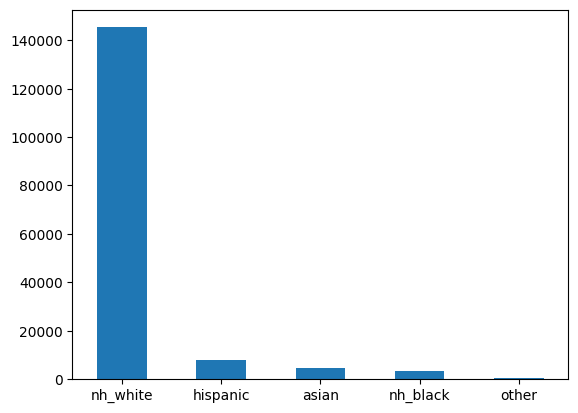

In [38]:
results_df['preds'].value_counts().plot.bar(x='lab', y='val', rot=0)

In [39]:
res_dict

{'nh_white': 145399,
 'hispanic': 7902,
 'asian': 4718,
 'nh_black': 3507,
 'other': 266}

In [40]:
for x in res_dict:
  print(f"{x} - {round(res_dict[x]/results_df.shape[0], 3)}%")

nh_white - 0.899%
hispanic - 0.049%
asian - 0.029%
nh_black - 0.022%
other - 0.002%


In [41]:
# prompt: Merge df and results_df based on name and names column

merged_df = df.merge(results_df, left_on='name', right_on='names')
merged_df.head()


,name,rank,count,prop100k,cum_prop100k,pctwhite,pctblack,pctapi,pctaian,pct2prace,pcthispanic,names,predictions,preds
0,Smith,1,2442977,828.19,828.19,70.9,23.11,0.5,0.89,2.19,2.4,Smith,3,nh_white
1,Johnson,2,1932812,655.24,1483.42,58.97,34.63,0.54,0.94,2.56,2.36,Johnson,3,nh_white
2,Williams,3,1625252,550.97,2034.39,45.75,47.68,0.46,0.82,2.81,2.49,Williams,2,nh_black
3,Brown,4,1437026,487.16,2521.56,57.95,35.6,0.51,0.87,2.55,2.52,Brown,3,nh_white
4,Jones,5,1425470,483.24,3004.80,55.19,38.48,0.44,1,2.61,2.29,Jones,3,nh_white


In [42]:
print(df.shape)
print(results_df.shape)
print(merged_df.shape)

(162253, 11)
(161792, 3)
(161792, 14)


In [46]:
merged_df.head()


,name,rank,count,prop100k,cum_prop100k,pctwhite,pctblack,pctapi,pctaian,pct2prace,pcthispanic,names,predictions,preds
0,Smith,1,2442977,828.19,828.19,70.9,23.11,0.5,0.89,2.19,2.4,Smith,3,nh_white
1,Johnson,2,1932812,655.24,1483.42,58.97,34.63,0.54,0.94,2.56,2.36,Johnson,3,nh_white
2,Williams,3,1625252,550.97,2034.39,45.75,47.68,0.46,0.82,2.81,2.49,Williams,2,nh_black
3,Brown,4,1437026,487.16,2521.56,57.95,35.6,0.51,0.87,2.55,2.52,Brown,3,nh_white
4,Jones,5,1425470,483.24,3004.80,55.19,38.48,0.44,1,2.61,2.29,Jones,3,nh_white


In [56]:
merged_df[merged_df['pctwhite'] > "50"].shape


(133804, 14)

In [55]:
merged_df[merged_df['pctwhite'] > "50"]['preds'].value_counts()

nh_white    129162
hispanic      2196
nh_black      1236
asian         1117
other           93
Name: preds, dtype: int64

In [57]:
merged_df[merged_df['pctblack'] > "50"].shape

(11865, 14)

In [58]:
merged_df[merged_df['pctblack'] > "50"]['preds'].value_counts()

nh_white    9539
nh_black    1998
asian        191
hispanic     118
other         19
Name: preds, dtype: int64

In [59]:
merged_df[merged_df['pcthispanic'] > "50"].shape

(19894, 14)

In [60]:
merged_df[merged_df['pcthispanic'] > "50"]['preds'].value_counts()

nh_white    12535
hispanic     6466
asian         498
nh_black      352
other          43
Name: preds, dtype: int64

In [62]:
merged_df[merged_df['pctwhite'] > "50"].shape[0]

133804

In [70]:
print(f"white - {merged_df[merged_df['pctwhite'] > '50']['preds'].value_counts()['nh_white']/merged_df[merged_df['pctwhite'] > '50'].shape[0]}")
print(f"black - {merged_df[merged_df['pctblack'] > '50']['preds'].value_counts()['nh_black']/merged_df[merged_df['pctblack'] > '50'].shape[0]}")
print(f"hispanic - {merged_df[merged_df['pcthispanic'] > '50']['preds'].value_counts()['hispanic']/merged_df[merged_df['pcthispanic'] > '50'].shape[0]}")

white - 0.9653074646497862
black - 0.1683944374209861
hispanic - 0.3250226198853926


In [72]:
merged_df.to_csv("/content/drive/MyDrive/Colab/ethnicolor/data/census_results.csv", index=False)